In [20]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from PIL import Image
from collections import defaultdict
import random
import glob

# Set up consistent styling
sns.set(style="whitegrid")

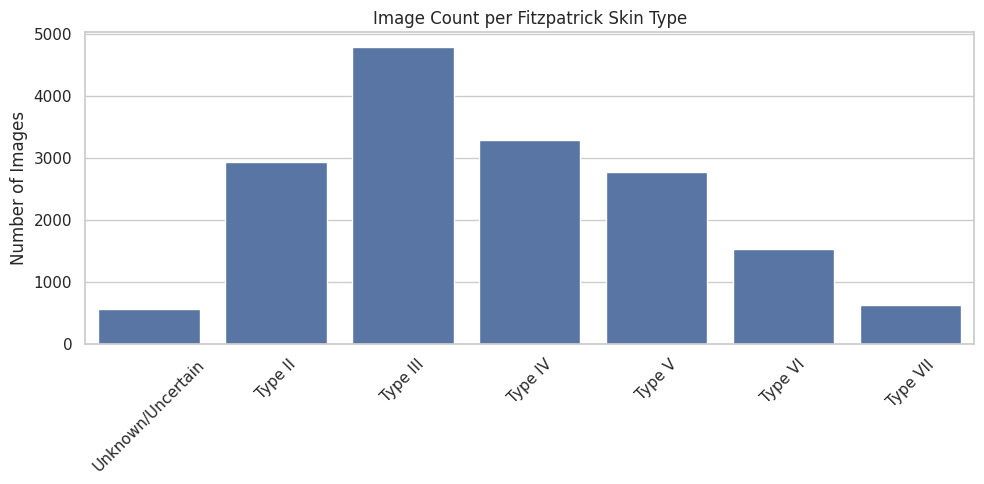

In [22]:
# Define root directory
DATA_DIR = os.path.abspath(os.path.join(os.getcwd(), "../../data/raw"))

# Fitzpatrick class labels (can be adjusted if needed)
CLASS_MAP = {
    "-1": "Unknown/Uncertain",
    "0": "Type I",
    "1": "Type II",
    "2": "Type III",
    "3": "Type IV",
    "4": "Type V",
    "5": "Type VI",
    "6": "Type VII"
}

# Load image counts per class
image_counts = {}
for label_folder in sorted(os.listdir(DATA_DIR)):
    folder_path = os.path.join(DATA_DIR, label_folder)
    if os.path.isdir(folder_path):
        count = len([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        image_counts[label_folder] = count

# Visualize class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=[CLASS_MAP.get(k, k) for k in image_counts.keys()], y=list(image_counts.values()))
plt.title("Image Count per Fitzpatrick Skin Type")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

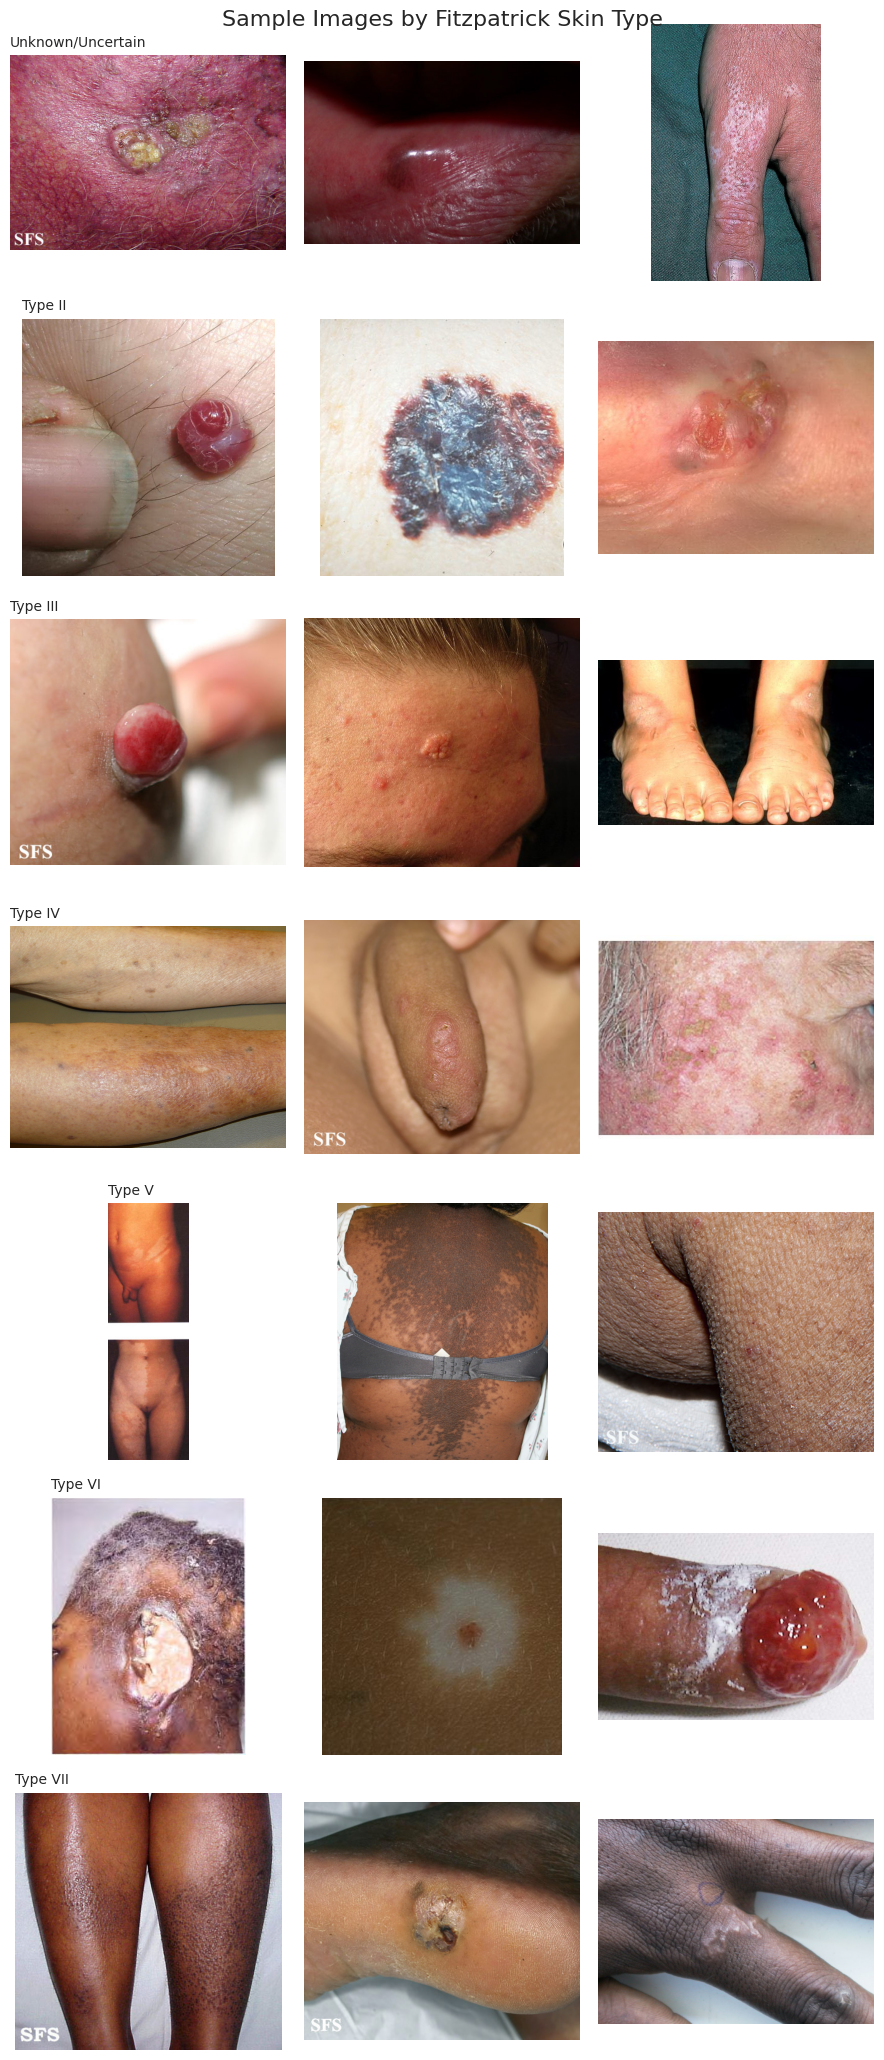

In [23]:
# Show 3 sample images per class
n_samples = 3
fig, axes = plt.subplots(len(image_counts), n_samples, figsize=(n_samples * 3, len(image_counts) * 3))

for row_idx, (label, count) in enumerate(sorted(image_counts.items(), key=lambda x: int(x[0]))):
    class_dir = os.path.join(DATA_DIR, label)
    img_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    samples = np.random.choice(img_files, size=min(n_samples, len(img_files)), replace=False)
    
    for col_idx, img_file in enumerate(samples):
        img_path = os.path.join(class_dir, img_file)
        img = Image.open(img_path).convert("RGB")
        axes[row_idx, col_idx].imshow(img)
        axes[row_idx, col_idx].axis('off')
        if col_idx == 0:
            axes[row_idx, col_idx].set_title(CLASS_MAP.get(label, label), fontsize=10, loc='left')

plt.suptitle("Sample Images by Fitzpatrick Skin Type", fontsize=16)
plt.tight_layout()
plt.show()

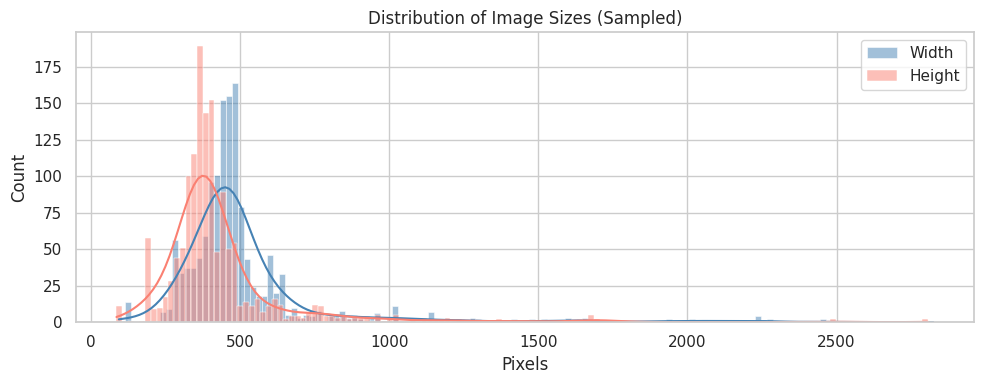

In [24]:
# Gather image dimensions for size distribution
image_sizes = defaultdict(list)

for label in image_counts.keys():
    folder = os.path.join(DATA_DIR, label)
    files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for f in np.random.choice(files, size=min(200, len(files)), replace=False):  # Sample up to 200 per class
        try:
            img = Image.open(os.path.join(folder, f)).convert("RGB")
            image_sizes['width'].append(img.width)
            image_sizes['height'].append(img.height)
        except:
            continue  # skip corrupted images

# Plot distribution
plt.figure(figsize=(10, 4))
sns.histplot(image_sizes['width'], kde=True, color='steelblue', label='Width')
sns.histplot(image_sizes['height'], kde=True, color='salmon', label='Height')
plt.legend()
plt.title("Distribution of Image Sizes (Sampled)")
plt.xlabel("Pixels")
plt.tight_layout()
plt.show()

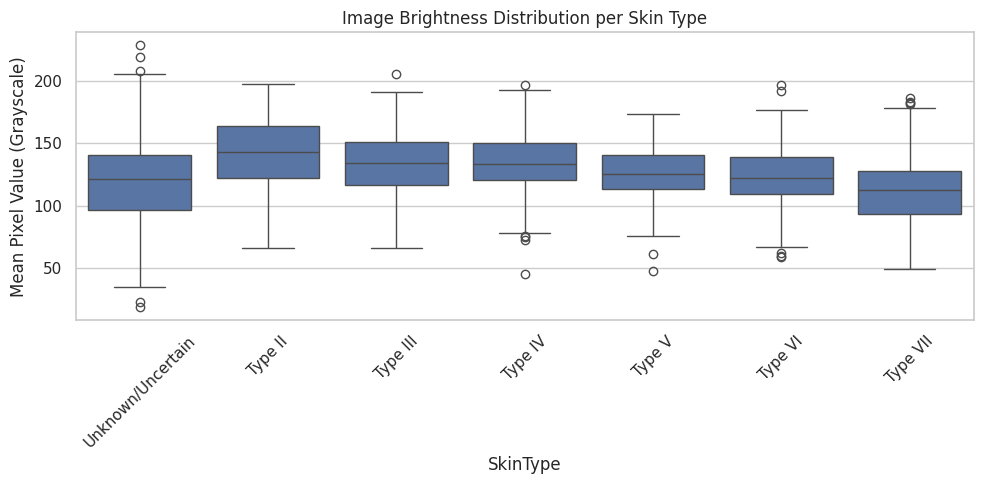

In [25]:
def compute_brightness(image_path):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    return np.array(img).mean()

brightness_data = []

for class_label in sorted(os.listdir(DATA_DIR)):
    class_path = os.path.join(DATA_DIR, class_label)
    if not os.path.isdir(class_path):
        continue
    sample_files = random.sample(os.listdir(class_path), min(300, len(os.listdir(class_path))))
    for filename in sample_files:
        try:
            path = os.path.join(class_path, filename)
            brightness = compute_brightness(path)
            brightness_data.append({
                'SkinType': CLASS_MAP.get(class_label, f"Type {class_label}"),
                'Brightness': brightness
            })
        except Exception:
            continue

# Plot
df_brightness = pd.DataFrame(brightness_data)
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_brightness, x='SkinType', y='Brightness')
plt.title('Image Brightness Distribution per Skin Type')
plt.ylabel('Mean Pixel Value (Grayscale)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

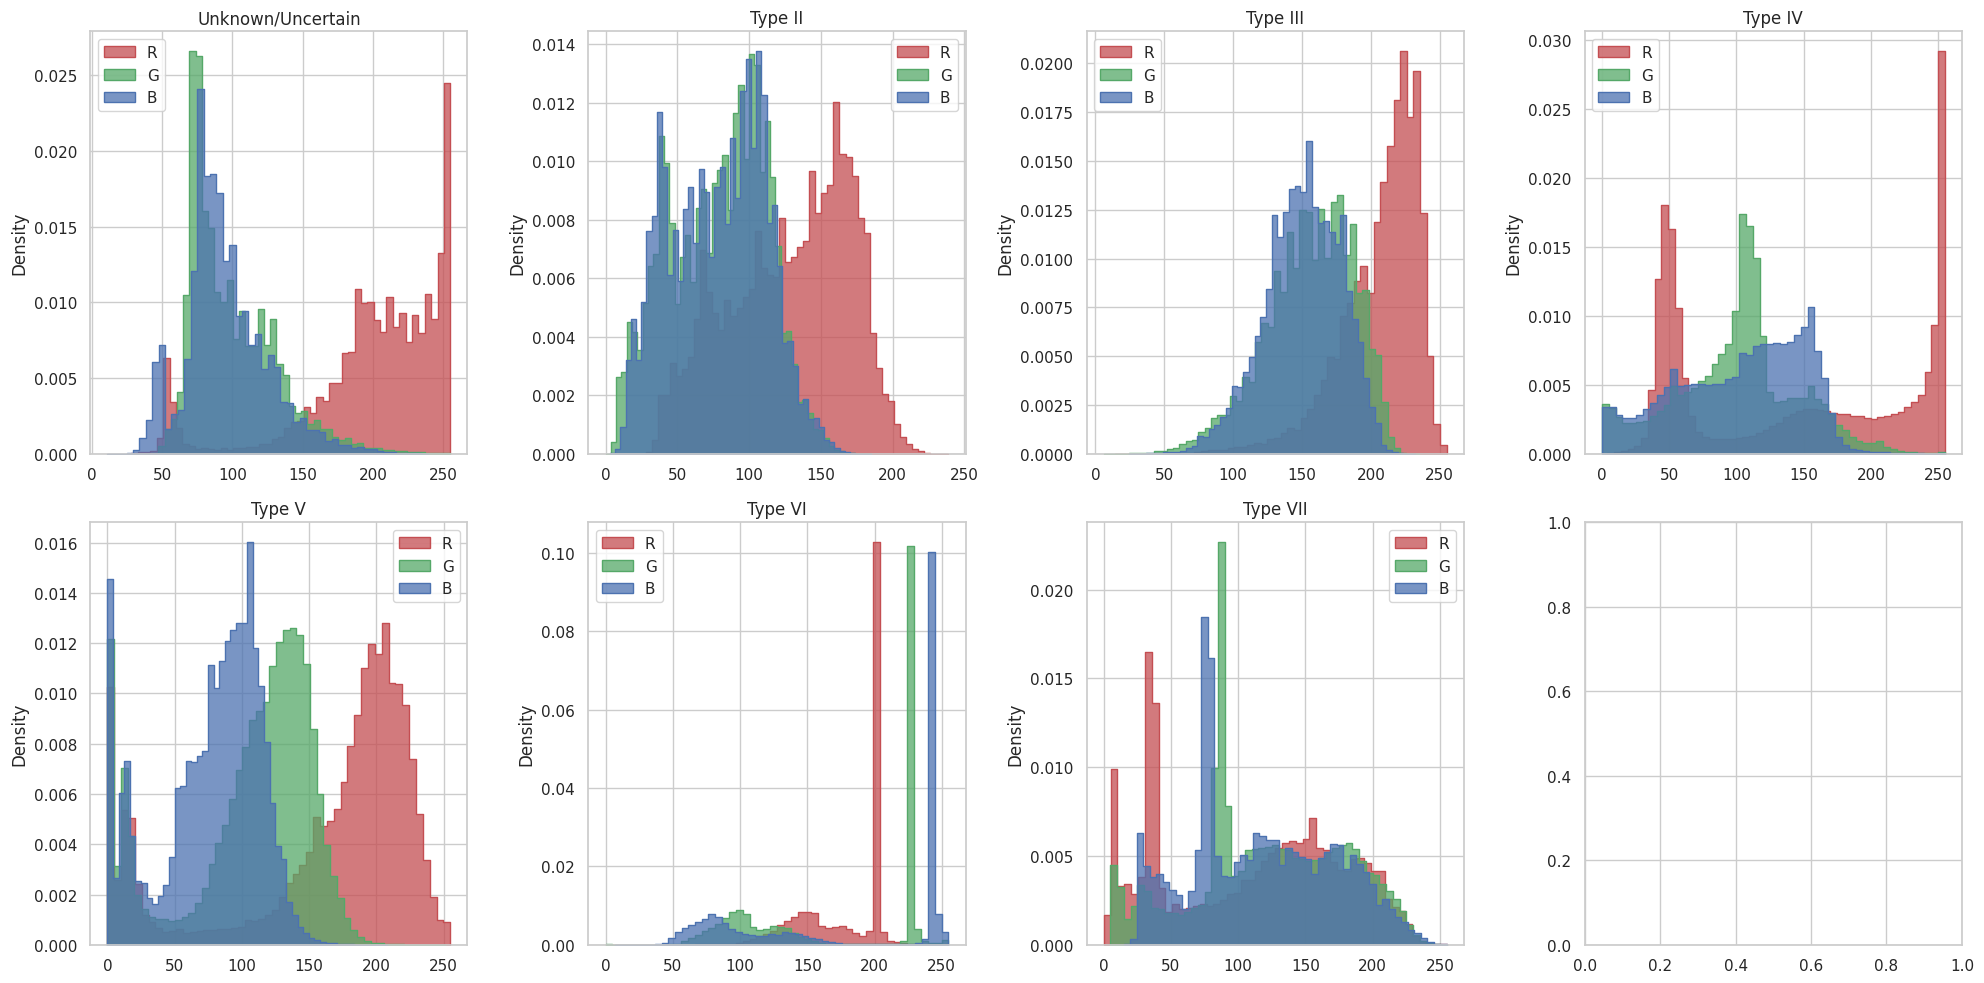

In [26]:
def plot_rgb_histogram(image_path, ax, title):
    image = Image.open(image_path).convert("RGB")
    r, g, b = image.split()
    for channel, color in zip((r, g, b), ['r', 'g', 'b']):
        hist = np.array(channel).flatten()
        sns.histplot(hist, color=color, element="step", stat="density", bins=50, ax=ax, label=color.upper())
    ax.set_title(title)
    ax.legend()

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, class_label in enumerate(sorted(os.listdir(DATA_DIR))):
    if not os.path.isdir(os.path.join(DATA_DIR, class_label)):
        continue
    sample_file = random.choice(os.listdir(os.path.join(DATA_DIR, class_label)))
    image_path = os.path.join(DATA_DIR, class_label, sample_file)
    plot_rgb_histogram(image_path, axes[idx], CLASS_MAP.get(class_label, f"Type {class_label}"))

plt.tight_layout()
plt.show()